# 03 Algorithms

## 3.12 Double Deep Q-Network

### Deep Q-Network 的缺陷
由于Deep Q-Network采用两套一样的网络Q网络进行计算，神经网络估算Q值本身在某些时候会产生一些正向或者负向的误差，每一次得到的都是神经网络当前估算的所有动作价值中的最大值，这样就导致Deep Q-Network在求解问题时，出现估值过高（算法倾向于选择估值较高的动作，从而累积正向误差）。

**例如：** 假设一种极端情形——在状态$s'$下所有动作的Q值均为0，即$Q(s', a_i)=0, \forall a_i$，但由于神经网络拟合误差存在，会对某些动作的估值有正向误差的存在，而算法却倾向于选择估值较高的动作($r+\gamma\max_a Q  > r + 0$)，从而累积正向误差。

**同理**，使用$Q(s, a)$来作为更新目标去更新上一步$Q$值时，同样存在过高估计的问题。**对于动作空间较大的任务，Deep Q-Network中的估值过高会非常严重，从而导致算法无法达到预期。**

### Double Deep Q-Network 核心思想
为了解决上述问题，Double Deep Q-Network（简称DDQN）被提出，其核心思想是使用两个独立训练的神经网络来分别选择动作和评估价值。具体来说，在计算目标网络的Q值时，我们不再直接使用贪心策略选取最大Q值的动作对应的Q值，而是通过主网络来选取动作，然后用这个动作去目标网络中寻找Q值，即使主网络在某个动作上存在比较严重的过高估计，但由于另一套神经网络的存在，这样就避免了估值过高的问题。

在Deep Q-Network算法中，有主网络$Q_w$和目标网络$Q_{w'}$两个网络，在寻找最大化动作值时，使用的是目标网络$Q_{w'}$，而在Double Deep Q-Network算法中，使用的是主网络$Q_w$来选择动作，然后使用目标网络$Q_{w'}$来计算相应的动作值，即TD Target为：
$$r + \gamma Q_{w'} \left(s', \arg\max_{a \in \cal A(s)} Q_w(s', a)\right)$$

###  Duble Deep Q-Network Algorithms
目标：从遵循行为策略$\pi_behavior$生成的经验数据中学习一个目标网络，用于近似最优动作价值函数$Q(s, a)$

- 一个是主网络($Q_{w}$)，另一个是目标网络($Q_{w'}$)、行为策略($\pi_{behavior}$)和$\mathcal{B} = \{(s, a, r, s')\}_{i=1}^{N}$、目标网络更新频率$C$、步长$\alpha$、折扣因子$\gamma$和探索率$\epsilon$
- $for \ e=1 \rightarrow E \ do$：
- $\quad$ 获取环境初始状态$s$
- $\quad$ $for \ t=1 \rightarrow T \ do$：
- $\quad\quad$ 根据训练网络$Q_{w}$以$\epsilon-Greedy$策略选择动作$a_t=\arg\max_{a}Q_{w}(s_t,a)$
- $\quad\quad$ 执行动作$a_t$，得到环境反馈$r_{t}$和下一状态$s_{t+1}$
- $\quad\quad$ 将$(s_t,a_t,r_{t},s_{t+1})$存入经验回放池$R$
- $\quad\quad$ 若经验回放池$R$中样本数量超过预定阈值，从经验回放池$R$中随机抽取批量数据${(s_j,a_j,r_j,s_{j+1})}_{j=1,2,\cdots,N}$
- $\quad\quad$ 对于每个数据，用目标网络计算$y_j=r_j+\gamma Q_{w'}(s_{j+1}, arg \max_{a'}Q_{w}(s', a'))$
- $\quad\quad$ 最小化目标损失$L=\frac{1}{N}\sum_{j=1}^N (y_j-Q_{w}(s_j,a_j))^2$，更新训练网络$Q_{w}$
- $\quad\quad$ 满足目标网络更新条件，更新目标网络$Q_{w'}=Q_{w}$
- $\quad$ $end \ for$
- $end \ for$

### Example

In [1]:
import time
import random
import collections

import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class ReplayBuffer:
    """ Experience Replay Buffer """

    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)


    def add(self, state, action, reward, next_state, done):
        """ Add Experience to Buffer """

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """ Sample a Batch of Experiences from Buffer """

        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        """ Return the Size of Buffer """

        return len(self.buffer)

In [3]:
class Qnetwork(nn.Module):
    """ Deep Q-Network """

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
def get_device():
    """ Get device """

    if torch.backends.mps.is_available():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [5]:
class DeepQNetwork:
    """ Deep Q-Network Algorithm """

    def __init__(self, env, state_dim, action_dim, hidden_dim=64, learning_rate=0.01, gamma=0.99, epsilon=0.1, epsilon_decay=0.99, target_update_freq=2, device=None, buffer_capacity=10000, use_double=True):
        """ Initialize Deep Q-Network """

        self.env = env
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.use_double = use_double

        self.device = device
        if self.device is None:
            self.device = get_device()

        # Initialize buffer
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)

        self.main_network = Qnetwork(state_dim, hidden_dim, action_dim).to(device)
        self.target_network = Qnetwork(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.main_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

        self.steps = 0
        self.returns = []

    def best_action(self, state):
        """ Best action for a given state according to the current network """
        with torch.no_grad():
            # Check if the state is empty or has the wrong shape
            if state is None or len(state) == 0 or len(state) != self.state_dim:
                raise ValueError(f"State is invalid: {state}")

            # Convert state to tensor
            state = torch.tensor(np.array([state]), dtype=torch.float32).to(self.device)

            # Ensure the state has the correct shape
            if state.shape != (1, self.state_dim):
                raise ValueError(f"State has incorrect shape: {state.shape}")

            # Get action from Q-network
            action = self.main_network(state).argmax().item()

        return action


    def take_action(self, state):
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            action = self.best_action(state)

        return action

    def update(self, batch):
        """ Update the Q-values using a batch of experiences """

        states = torch.tensor(batch['states'], dtype=torch.float32).to(self.device)
        actions = torch.tensor(batch['actions'], dtype=torch.long).to(self.device)
        rewards = torch.tensor(batch['rewards'], dtype=torch.float32).to(self.device)
        next_states = torch.tensor(batch['next_states'], dtype=torch.float32).to(self.device)
        dones = torch.tensor(batch['dones'], dtype=torch.float32).to(self.device)

        # Compute Q-values for the current states and actions
        current_q_values = self.main_network(states).gather(1, actions.view(-1, 1))
        # Compute max target Q-values for the next states using the target network
        if self.use_double:
            next_actions = self.main_network(next_states).max(axis=1)[1].view(-1, 1)
            max_target_q_values = self.target_network(next_states).gather(1, next_actions)
        else:
            max_target_q_values = self.target_network(next_states).max(axis=1)[0].view(-1, 1)
        # Compute the target Q-values using the Bellman equation with discount factor gamma and rewards
        targets = rewards.view(-1, 1) + self.gamma * max_target_q_values * (1 - dones.view(-1, 1))
        # Compute the loss using mean squared error between current Q-values and target Q-values
        loss = self.criterion(current_q_values, targets)
        # Backpropagate the loss and update the network parameters using Adam optimizer with learning rate lr
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Update the target network parameters using a soft update with tau factor to track slowly changing targets
        if self.target_update_freq > 0 and self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.main_network.state_dict())

        self.steps += 1

    def train(self, epochs=100, batch_size=32):
        """ Train the DQN agent on the given number of epochs with a batch size """

        for i in range(10):
            with tqdm(total=epochs // 10, desc=f"Iteration {i+1}") as pbar:
                for epoch in range(epochs // 10):
                    state, info = self.env.reset()

                    done = False
                    gamma_power = 1
                    episode_return = 0
                    while not done:
                        action = self.take_action(state)
                        next_state, reward, terminated, truncated, info = self.env.step(action)
                        done = terminated or truncated
                        self.replay_buffer.add(state, action, reward, next_state, done)
                        state = next_state

                        episode_return += reward * gamma_power
                        gamma_power *= self.gamma

                        if self.replay_buffer.size() >= batch_size:
                            state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(batch_size)

                            batch = {
                                "states": state_batch,
                                "actions": action_batch,
                                "rewards": reward_batch,
                                "next_states": next_state_batch,
                                "dones": done_batch
                            }
                            self.update(batch)

                    self.returns.append(episode_return)
                    if (epoch + 1) % 10 == 0:
                        pbar.set_postfix(
                            {
                                'epoch': epochs / 10 * i + epoch + 1,
                                'return': np.mean(self.returns),
                                'epsilon': self.epsilon
                            }
                        )
                    pbar.update(1)

                    self.epsilon *= self.epsilon_decay
                    self.epsilon = max(self.epsilon, 0.01)

    def visualize(self, delay=0.5):
        state, info = self.env.reset()
        done = False

        while not done:
            self.env.render()
            action = self.best_action(state)
            state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            time.sleep(delay)

        self.env.render()
        self.env.close()

In [6]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

In [7]:
name = 'CartPole-v1'
environment = gym.make(name, render_mode='rgb_array')
environment.reset()

(array([-0.02799095,  0.02360128,  0.00923306,  0.04231224], dtype=float32),
 {})

In [ ]:
agent = DeepQNetwork(
    env=environment,
    state_dim=environment.observation_space.shape[0],
    action_dim=environment.action_space.n,
    hidden_dim=128,
    learning_rate=0.001,
    gamma=0.98,
    epsilon=1,
    epsilon_decay=0.995,
    target_update_freq=10,
    buffer_capacity=1000,
    device=get_device(),
    use_double=True
)

In [9]:
agent.train(
    epochs=1000,
    batch_size=128
)

Iteration 10: 100%|██████████| 100/100 [03:07<00:00,  1.88s/it, epoch=1e+3, return=42, epsilon=0.01]  


In [10]:
environment = gym.make(name, render_mode='human')
environment.reset()

agent.env = environment
agent.visualize()

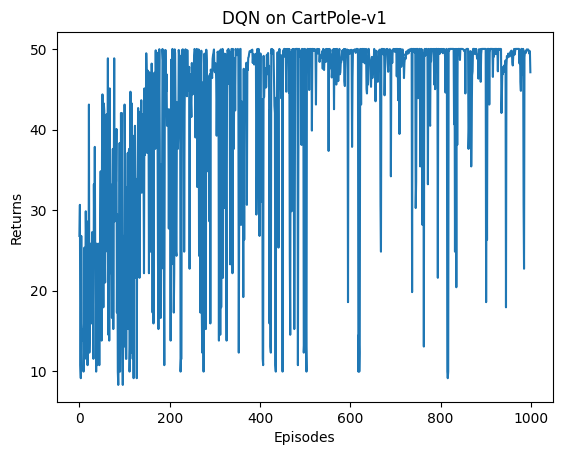

In [11]:
episodes = list(range(len(agent.returns)))
plt.plot(episodes, agent.returns)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(name))
plt.show()

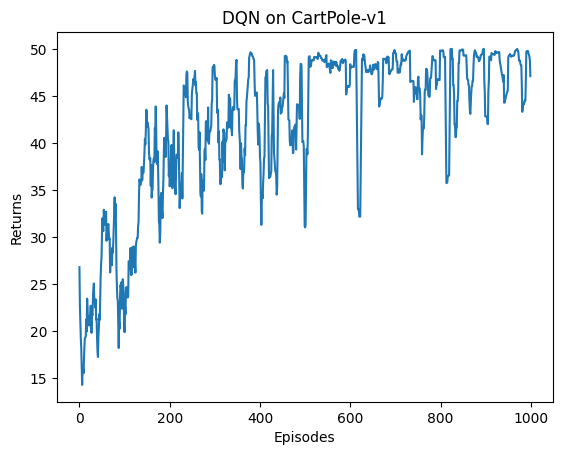

In [12]:
mv_return = moving_average(agent.returns, 9)
plt.plot(episodes, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(name))
plt.show()